### Make necessary imports

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../batchflow')

from batchflow import Config, Pipeline, B, V
from batchflow.opensets import MNIST
from batchflow.models.torch import TorchModel
from batchflow.models.metrics import ClassificationMetrics

### Load dataset

In [2]:
mnist = MNIST()

### Define model configs

In [3]:
config = {
    'inputs/images/shape': (1, 28, 28),
    'inputs/images/data_format': 'channels_first',
    'inputs/images/classes': 10,

    'initial_block/inputs': 'images',
    'body/layout': 'f',
    'body/units': 10,

    'output/predicted': ['proba', 'labels'],
    'optimizer': 'Adam',
    'loss': 'ce',
}

### Define train pipeline

In [4]:
train_template = (Pipeline()
    .init_variable('loss', default=[])
    .to_array('float32', 'channels_first')
    .init_model('dynamic', TorchModel, 'model', config)
    .train_model('model', B('images'), B('labels'), fetches='loss', save_to=V('loss', mode='a'))
)

train_pipeline = mnist.train >> train_template

### Run train pipeline

In [5]:
BATCH_SIZE = 64
N_ITERS = 200
train_pipeline.run(batch_size=BATCH_SIZE, n_iters=N_ITERS, bar='n', shuffle=True, drop_last=True);

### Plot loss

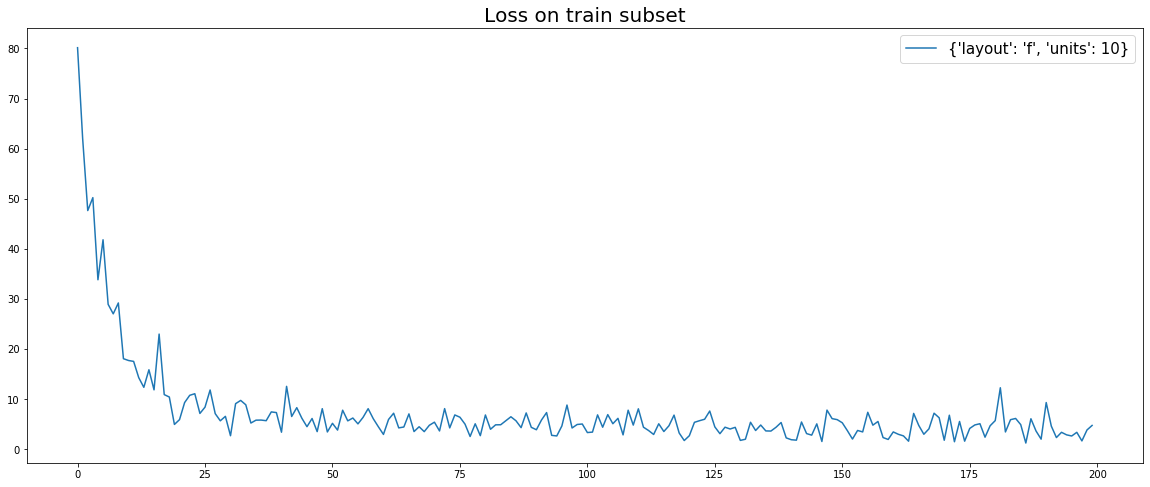

In [6]:
plt.figure(figsize=(20,8))
loss = np.asarray(train_pipeline.v('loss'))
axes = sns.lineplot(data=loss, palette='Set2').set_title('Loss on train subset', fontsize=20)
plt.legend([str(train_pipeline.m('model').config['body'])], prop={'size': 15});

### Define test pipeline

In [7]:
test_template = (Pipeline()
    .init_variable('predictions')
    .init_variable('metrics')
    .import_model('model', train_pipeline)
    .to_array('float32', 'channels_first')
    .predict_model('model', B.images, fetches='predicted_proba', save_to=V.predictions)
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', axis=1, save_to=V('metrics', mode='u'))
)

test_pipeline = mnist.test >> test_template

### Run test pipeline

In [8]:
test_pipeline.run(batch_size=1, n_epochs=1, bar='n');

### Plot confusion matrix

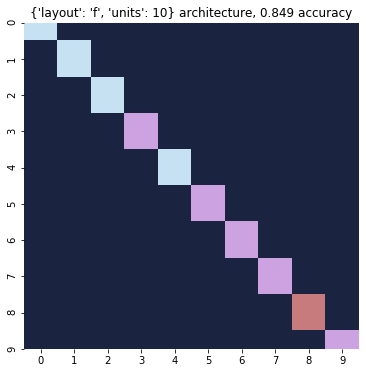

In [9]:
plt.figure(figsize=(6,6))
model_body = str(test_pipeline.m('model').config['body'])
metrics = test_pipeline.get_variable('metrics')
accuracy = metrics.evaluate('accuracy')
confusion_matrix = metrics._confusion_matrix.squeeze()
title = '{0} architecture, {1:.3f} accuracy'.format(model_body, accuracy)
sns.heatmap(confusion_matrix, cmap=sns.color_palette('cubehelix'), cbar=False).set_title(title);